# Loading code and data

## When loading notebook for the first time:

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!mkdir /root/.kaggle

In [ ]:
########################################
########## Add kaggle API key ##########
########################################

!echo '{"username":"aliceallafort","key":"0d34479935dac419278ed5dce8d32974"}' > ~/.kaggle/kaggle.json

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!git clone https://github.com/TigerManon/drive-on-mars.git

Cloning into 'drive-on-mars'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 203 (delta 31), reused 33 (delta 25), pack-reused 144
Receiving objects: 100% (203/203), 25.85 MiB | 15.02 MiB/s, done.
Resolving deltas: 100% (76/76), done.


In [ ]:
%cd drive-on-mars/
%mkdir raw_data
%cd raw_data

/content/drive-on-mars
/content/drive-on-mars/raw_data


In [ ]:
!kaggle datasets download yash92328/ai4mars-terrainaware-autonomous-driving-on-mars

100% 5.72G/5.72G [04:53<00:00, 23.1MB/s]
100% 5.72G/5.72G [04:53<00:00, 20.9MB/s]


In [ ]:
!unzip -q ai4mars-terrainaware-autonomous-driving-on-mars.zip

In [ ]:
!rm ai4mars-terrainaware-autonomous-driving-on-mars.zip

In [ ]:
%cd ../

/content/drive-on-mars


In [ ]:
%ls

 dockerfile       Jinjin_draft.ipynb   README.md         'U-Net pretrained.ipynb'
 drive_on_mars/   notebooks/           requirements.txt  'U-Net Test-Copy1.ipynb'
 First_model.h5   raw_data/            setup.py           Untitled.ipynb


## When reloading the notebook

In [ ]:
%ls

In [ ]:
%pwd

'/content'

In [ ]:
%cd drive-on-mars/

/content/drive-on-mars


sample_data/


# Loading Libraries


In [ ]:
#!pip install git+https://github.com/qubvel/segmentation_models
!pip install segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.1 MB/s eta 0:00:00


In [ ]:
# Data Visualisation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tqdm import tqdm


from tensorflow.keras import callbacks
from sklearn.model_selection import train_test_split


In [ ]:
# Segmentation Models

############# Alice #################
# Had to add this to make sm work in colab
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras
import segmentation_models as sm
#####################################

import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf


# Unet From Scratch Model Tuning


## Data Generator for Unet Scratch Model

In [ ]:
#image_folder = "raw_data/ai4mars-dataset-merged-0.1/msl/images/edr"
#label_folder = "raw_data/ai4mars-dataset-merged-0.1/msl/labels/train"

In [ ]:
# 0 - soil
# 1 - bedrock
# 2 - sand
# 3 - big rock
# 255 -> 4 - NULL (no label)

In [ ]:
# Define a customized data generator
class UnetDataGenerator(keras.utils.Sequence):
    def __init__(self, image_folder, label_folder, input_shape, batch_size, num_classes, subfolder, split_percent):
        self.image_folder       = image_folder
        self.label_folder       = label_folder
        self.input_shape        = input_shape
        self.batch_size         = batch_size
        self.num_classes        = num_classes
        self.subfolder          = subfolder
        self.split_percent      = split_percent
        self.path_df            = self.make_df()
        self.split_df()

    def __len__(self):
        print("Length of generator:", len(self.path_df))
        return math.ceil(len(self.path_df) / float(self.batch_size))

    def make_df(self):
        img_list = [f for f in os.listdir(self.image_folder) if f.endswith('.JPG')]
        lab_list = [f for f in os.listdir(self.label_folder) if f.endswith('.png')]

        path_df = pd.DataFrame(columns=["image_path","label_path"])

        for label_name in lab_list:
            image_name = label_name.replace('.png', '.JPG')
            if image_name in img_list:
                path_df = path_df.append({
                    "image_path": os.path.join(self.image_folder, image_name),
                    "label_path": os.path.join(self.label_folder, label_name)
                }, ignore_index=True)
        return path_df

    def split_df(self):
        if self.subfolder == "train":
            self.path_df = self.path_df.iloc[:int(len(self.path_df) * self.split_percent)]
        elif self.subfolder == "val":
            self.path_df = self.path_df.iloc[int(len(self.path_df) * self.split_percent):]


    def __getitem__(self, index):
        input_images  = []
        output_targets = []

        #-------------------------------#
        #   Calculate start indice and end indice of the batch
        #-------------------------------#
        start = index * self.batch_size
        end = min((index + 1) * self.batch_size, len(self.path_df)) # Make sure that we can load all the data of the last batch

        for i in range(start, end):

            #-------------------------------#
            #   Get image path and label path of each batch from path_df
            #-------------------------------#
            jpg = self.path_df.iloc[i]["image_path"]
            png = self.path_df.iloc[i]["label_path"]

            #-------------------------------#
            #   Transform images and labels to numpy array, resize them
            #   Set the background label to 4
            #-------------------------------#

            jpg = cv2.imread(jpg)
            png = cv2.imread(png,0)

            jpg = cv2.resize(jpg, dsize = (int(self.input_shape[0]), int(self.input_shape[1])))/255
            png = cv2.resize(png, dsize = (int(self.input_shape[0]), int(self.input_shape[1])),
                                      interpolation = cv2.INTER_NEAREST)

            png[png == 255] = 4

            #-------------------------------------------------------#
            #   One hot encode the labels
            #-------------------------------------------------------#

            seg_labels = np.eye(self.num_classes)[png.reshape([-1])]
            seg_labels = seg_labels.reshape((int(self.input_shape[0]), int(self.input_shape[1]), self.num_classes))

            input_images.append(jpg)
            output_targets.append(seg_labels)

        input_images = np.asarray(input_images)
        output_targets = np.array(output_targets)


        return input_images, output_targets




In [ ]:
# image and label directories paths

image_folder = "raw_data/ai4mars-dataset-merged-0.1/msl/images/edr"
label_folder = "raw_data/ai4mars-dataset-merged-0.1/msl/labels/train"

In [ ]:
# Some inputs
batch_size = 16
num_classes = 5
input_shape = (256,256,3)
split_percent = 0.8
height=input_shape[0]
width=input_shape[1]
channels=input_shape[2]

In [ ]:
%%time
# Train dataset generator and validation dataset generator
traingen = UnetDataGenerator(image_folder,
                             label_folder,
                             input_shape,
                             batch_size,
                             num_classes,
                             "train",
                             split_percent)

valgen = UnetDataGenerator(image_folder,
                           label_folder,
                           input_shape,
                           batch_size,
                           num_classes,
                           "val",
                           split_percent)

Streaming output truncated to the last 5000 lines.
<ipython-input-65-bbb7ff263b0a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
<ipython-input-65-bbb7ff263b0a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
<ipython-input-65-bbb7ff263b0a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
<ipython-input-65-bbb7ff263b0a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
<ipython-input-65-bbb7ff263b0a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conc

CPU times: user 48 s, sys: 2.22 s, total: 50.2 s
Wall time: 49.2 s


<ipython-input-65-bbb7ff263b0a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
<ipython-input-65-bbb7ff263b0a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
<ipython-input-65-bbb7ff263b0a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
<ipython-input-65-bbb7ff263b0a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
<ipython-input-65-bbb7ff263b0a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
<ipython-i

## Unet from Scratch Model Initialization

In [ ]:
# Initializing an Unet model
def Unet_model():
    """
    Initialize the U-Net model
    """
    #################
    #    Params    #
    #################

    n_classes=5
    height=256
    width=256
    channels=3
    inputs = Input((height, width, channels))

    ############################
    # Down Sampling - Encoding #
    ############################

    conv_1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    conv_1 = Dropout(0.1)(conv_1)
    conv_1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_1)
    pool_1 = MaxPooling2D((2, 2))(conv_1)

    conv_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_1)
    conv_2 = Dropout(0.1)(conv_2)
    conv_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_2)
    pool_2 = MaxPooling2D((2, 2))(conv_2)

    conv_3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_2)
    conv_3 = Dropout(0.1)(conv_3)
    conv_3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_3)
    pool_3 = MaxPooling2D((2, 2))(conv_3)

    conv_4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_3)
    conv_4 = Dropout(0.1)(conv_4)
    conv_4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_4)
    pool_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

    conv_5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_4)
    conv_5 = Dropout(0.2)(conv_5)
    conv_5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_5)

    ############################
    #  Up Sampling - Decoding  #
    ############################

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv_5)
    u6 = concatenate([u6, conv_4])
    conv_6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    conv_6 = Dropout(0.2)(conv_6)
    conv_6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv_6)
    u7 = concatenate([u7, conv_3])
    conv_7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    conv_7 = Dropout(0.1)(conv_7)
    conv_7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv_7)
    u8 = concatenate([u8, conv_2])
    conv_8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    conv_8 = Dropout(0.2)(conv_8)
    conv_8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv_8)
    u9 = concatenate([u9, conv_1], axis=3)
    conv_9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    conv_9 = Dropout(0.1)(conv_9)
    conv_9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_9)

    ################
    # Output Layer #
    ################

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(conv_9)

    ########################
    # Model initialization #
    ########################

    model = Model(inputs=[inputs], outputs=[outputs])

    model.summary()

    return model


In [ ]:
# Initializing and compiling model
model = Unet_model()
#model.compile(optimizer='adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

metrics=['accuracy', iou_score]
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_58 (Conv2D)          (None, 256, 256, 16)         448       ['input_5[0][0]']             
                                                                                                  
 dropout_18 (Dropout)        (None, 256, 256, 16)         0         ['conv2d_58[0][0]']           
                                                                                                  
 conv2d_59 (Conv2D)          (None, 256, 256, 16)         2320      ['dropout_18[0][0]']          
                                                                                            

## Unet Scratch Model Training

In [ ]:
%%time
MODEL = "unet_4deep_16in_whole_data_img_scaled_256pix"

modelCheckpoint = callbacks.ModelCheckpoint("{}.h5".format(MODEL),
                                            monitor="val_iou_score",
                                            save_best_only = False)

LR_reducer = callbacks.ReduceLROnPlateau(patience = 3,
                                         monitor="val_iou_score",
                                         factor = 0.1,
                                         min_lr = 0
                                        )

early_stopper = callbacks.EarlyStopping(patience = 5,
                                        monitor="val_iou_score",
                                        restore_best_weights=True)



history = model.fit(traingen,
          validation_data=valgen,
          epochs=100,
          callbacks = [modelCheckpoint, LR_reducer, early_stopper],
          verbose=1)

Length of generator: 3213
Length of generator: 12851
Length of generator: 12851
Epoch 1/100
Length of generator: 12851
804/804 [==============================] - ETA: 0s - loss: 0.9880 - accuracy: 0.5764 - iou_score: 0.2015Length of generator: 3213
Length of generator: 3213
Length of generator: 3213
Length of generator: 3213
804/804 [==============================] - 305s 373ms/step - loss: 0.9880 - accuracy: 0.5764 - iou_score: 0.2015 - val_loss: 0.7695 - val_accuracy: 0.6983 - val_iou_score: 0.2746 - lr: 0.0010
Length of generator: 12851
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Length of generator: 12851
804/804 [==============================] - ETA: 0s - loss: 0.6771 - accuracy: 0.7452 - iou_score: 0.3288Length of generator: 3213
Length of generator: 3213
Length of generator: 3213
804/804 [==============================] - 295s 367ms/step - loss: 0.6771 - accuracy: 0.7452 - iou_score: 0.3288 - val_loss: 0.6026 - val_accuracy: 0.7684 - val_iou_score: 0.3834 - lr: 0.0010
Length of generator: 12851
Epoch 3/100
Length of generator: 12851
804/804 [==============================] - ETA: 0s - loss: 0.5656 - accuracy: 0.7881 - iou_score: 0.3871Length of generator: 3213
Length of generator: 3213
Length of generator: 3213
804/804 [==============================] - 303s 377ms/step - loss: 0.5656 - accuracy: 0.7881 - iou_score: 0.3871 - val_loss: 0.5522 - val_accuracy: 0.7912 - val_iou_score: 0.3901 - lr: 0.0010
Length of generator: 12851
Epoch 4/100
Length of generator: 12851
804/804 [==============================] - ETA: 0s - loss: 0.5157 - accuracy: 0.8057 - iou_sc

In [ ]:
history.history

{'loss': [0.9880380630493164,
  0.6770715713500977,
  0.5656445026397705,
  0.5157241821289062,
  0.429847776889801,
  0.4133259057998657],
 'accuracy': [0.5763981938362122,
  0.745175838470459,
  0.7880630493164062,
  0.8057262897491455,
  0.8348796367645264,
  0.8406023979187012],
 'iou_score': [0.20146740972995758,
  0.3287636935710907,
  0.38712891936302185,
  0.41366976499557495,
  0.4655986428260803,
  0.4771044850349426],
 'val_loss': [0.7695260643959045,
  0.6026301383972168,
  0.552152693271637,
  0.5004117488861084,
  0.4282575249671936,
  0.4272347688674927],
 'val_accuracy': [0.698346734046936,
  0.7684037089347839,
  0.7911995053291321,
  0.8105074167251587,
  0.8343513011932373,
  0.8348263502120972],
 'val_iou_score': [0.27457618713378906,
  0.3833996653556824,
  0.3900831937789917,
  0.4318521320819855,
  0.4693751633167267,
  0.47415146231651306],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.000100000005, 0.000100000005]}

In [ ]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    # ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['iou_score'], label='train iou'  + exp_name)
    ax2.plot(history.history['val_iou_score'], label='val iou'  + exp_name)
    # ax2.set_ylim(0, 0.5)
    ax2.set_title('iou')
    ax2.legend()
    plt.show()

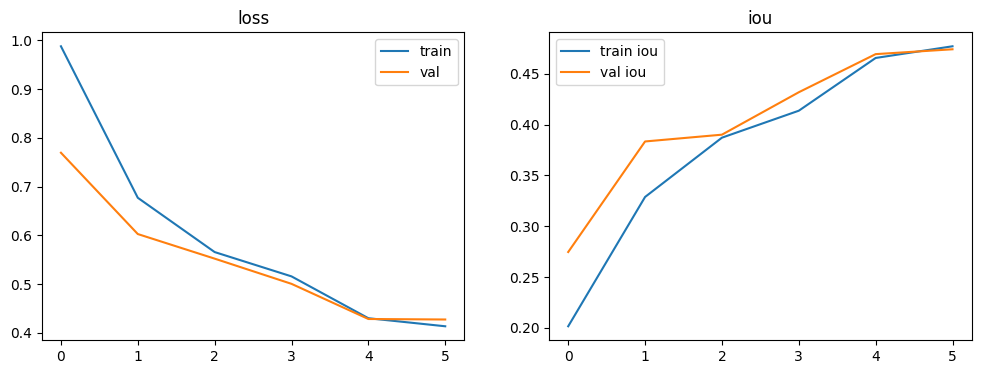

In [ ]:
plot_history(history)

## Model Saving

In [ ]:
!mkdir raw_data/models
!ls raw_data

mkdir: cannot create directory ‘raw_data/models’: File exists
ai4mars-dataset-merged-0.1  models


In [79]:
model.save(f'raw_data/models/{MODEL}.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [80]:
!ls raw_data/models

unet_4deep_16in_whole_data_img_256pix.h5	 Unet_ResBackBone_ImageNet_img_256pix.h5
unet_4deep_16in_whole_data_img_scaled_256pix.h5


In [81]:

%cp raw_data/models/unet_4deep_16in_whole_data_img_scaled_256pix.h5 /content/drive/MyDrive/data/models

## Training Records

09/12/2023 23:34




*   Model: unet_4deep_16in_256pix
*   optimizer: 'adam', loss: sm.losses.bce_jaccard_loss, metrics: sm.metrics.
    iou_score
*   Trainable params: 1941173
*   Data: 12851 train images; 3213 val images, loaded,preporcessed,splited by   
      UnetDataGenerator
*   Training: set up for 100 epochs, stopped at 6 epochs by early stopping,
    Wall time: 29min 52s, GPU V100
*   'loss': 0.5861780643463135,
    'iou_score': 0.5779913663864136,
    'val_loss':  0.5868656635284424],
    'val_iou_score': 0.5775318145751953,
    'lr': [0.001, 0.001, 0.001, 0.001, 0.000100000005, 0.000100000005]





10/12/2023 03:34

* Model: unet_4deep_16in_1024pix

* optimizer: 'adam', loss: sm.losses.bce_jaccard_loss, metrics: sm.metrics.
  iou_score
* Trainable params: 1941173
* Data: image and label size: 1024, 12851 train images; 3213 val images, loaded, preporcessed,splited by UnetDataGenerator
* Training: set up for 100 epochs, stopped at 6 epochs by early stopping,        Wall time: 2h 8min 6s, GPU V100
* 'loss':  0.6727234125137329, 'iou_score': 0.50568687915802, 'val_loss': 0.6704270839691162, 'val_iou_score': 0.5068952441215515, 'lr': [0.001, 0.001, 0.001, 0.001, 0.000100000005, 0.000100000005]




10/12/2023 10:34

* Model: unet_4deep_64in_256pix

* optimizer: 'adam', loss: sm.losses.bce_jaccard_loss, metrics: sm.metrics. iou_score

* Trainable params: 31032005

* Data: image and label size: 256, 12851 train images; 3213 val images, loaded, preporcessed,splited by UnetDataGenerator

* Training: set up for 100 epochs, stopped at 6 epochs by early stopping, Wall time: 29min 3s, GPU A100

* 'loss': 0.5815900564193726, 'iou_score': 0.580341637134552, 'val_loss': 0.59281826019287112, 'val_iou_score': 0.5689619183540344, 'lr': [0.001, 0.001, 0.001, 0.001, 0.000100000005, 0.000100000005] Slightly overfitted

10/12/2023 16:34

* Model: Unet_ResBackBone_ImageNet_img_256pix

* optimizer: 'adam', loss: sm.losses.bce_jaccard_loss, metrics: sm.metrics. iou_score

* Total params: 24456734 (93.30 MB)
Trainable params: 24439384 (93.23 MB)
Non-trainable params: 17350 (67.77 KB)

* Data: image and label size: 256, 12851 train images; 3213 val images, loaded, preporcessed,splited by UnetDataGenerator

* Training: set up for 100 epochs, stopped at 6 epochs by early stopping, Wall time: 27min 3s, GPU A100

* 'loss': 0.4621942937374115
 'accuracy': 0.8795599341392517
 'iou_score': 0.659989595413208
 'val_loss': 0.48931652307510376
 'val_accuracy':  0.8699352741241455
 'val_iou_score': 0.6389757394790649
 'lr': [0.001, 0.001, 0.001, 0.001, 0.000100000005, 0.000100000005]}


10/12/2023 18:34

* Model: Unet_ResBackBone_ImageNet_img_256pix

* optimizer: 'adam', loss:'categorical_crossentropy', metrics: accuracy, iou_score

* Total params: 24456734 (93.30 MB)
Trainable params: 24439384 (93.23 MB)
Non-trainable params: 17350 (67.77 KB)

* Data: image and label size: 256, 12851 train images; 3213 val images, loaded, preporcessed,splited by UnetDataGenerator

* Training: set up for 100 epochs, stopped at 6 epochs by early stopping, Wall time: 30min, GPU A100

* 'loss': 0.28132763504981995
 'accuracy': 0.8859129548072815
 'iou_score': 0.5797572731971741
 'val_loss': 0.31182384490966797
 'val_accuracy':  0.8733996152877808
 'val_iou_score': 0.5677776336669922
 'lr': [0.001, 0.001, 0.001, 0.001, 0.000100000005, 0.000100000005]


## History

In [ ]:
# %%time
# es = callbacks.EarlyStopping(patience=2,restore_best_weights=True)
# #modelCheckpoint = callbacks.ModelCheckpoint("{}.h5".format('First_model'), monitor="val_loss", verbose=0, save_best_only=False)


# history = model.fit(X_train, y_train,
#           batch_size=16,
#           epochs=10,
#           validation_split=0.3,
#           callbacks=[es],
#           verbose=1)


Epoch 1/10
16/16 [==============================] - 26s 1s/step - loss: 1.4578 - iou_score: 0.0815 - val_loss: 1.2656 - val_iou_score: 0.0958
Epoch 2/10
16/16 [==============================] - 23s 1s/step - loss: 1.2874 - iou_score: 0.1014 - val_loss: 1.2581 - val_iou_score: 0.0978
Epoch 3/10
16/16 [==============================] - 24s 2s/step - loss: 1.2503 - iou_score: 0.1036 - val_loss: 1.2078 - val_iou_score: 0.1063
Epoch 4/10
16/16 [==============================] - 24s 2s/step - loss: 1.2265 - iou_score: 0.1115 - val_loss: 1.1993 - val_iou_score: 0.1112
Epoch 5/10
16/16 [==============================] - 24s 2s/step - loss: 1.2203 - iou_score: 0.1126 - val_loss: 1.2105 - val_iou_score: 0.1098
Epoch 6/10
16/16 [==============================] - 24s 1s/step - loss: 1.2093 - iou_score: 0.1202 - val_loss: 1.1699 - val_iou_score: 0.1257
Epoch 7/10
16/16 [==============================] - 24s 2s/step - loss: 1.1916 - iou_score: 0.1295 - val_loss: 1.1409 - val_iou_score: 0.1381
Epoch 

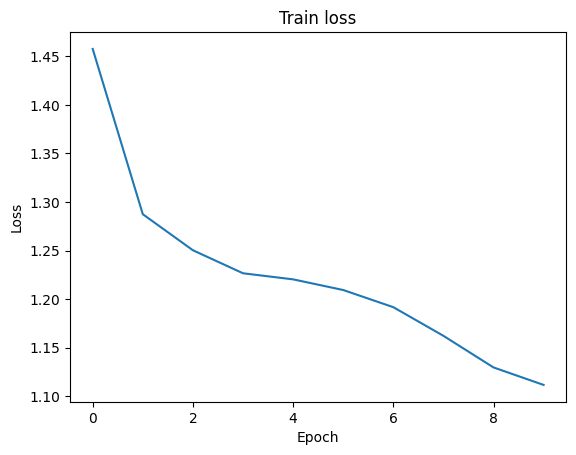

In [ ]:
# plot_history(history)

In [ ]:
%%time
es = callbacks.EarlyStopping(patience=2,restore_best_weights=True)
#modelCheckpoint = callbacks.ModelCheckpoint("{}.h5".format('First_model'), monitor="val_loss", verbose=0, save_best_only=False)


history = model.fit(X_train, y_train,
          batch_size=16,
          epochs=100,
          validation_split=0.3,
          callbacks=[es],
          verbose=1)

Epoch 1/100
16/16 [==============================] - 24s 1s/step - loss: 1.1298 - iou_score: 0.1686 - val_loss: 1.1122 - val_iou_score: 0.1594
Epoch 2/100
16/16 [==============================] - 21s 1s/step - loss: 1.0876 - iou_score: 0.1826 - val_loss: 1.1037 - val_iou_score: 0.1642
Epoch 3/100
16/16 [==============================] - 21s 1s/step - loss: 1.0782 - iou_score: 0.1859 - val_loss: 1.1144 - val_iou_score: 0.1632
Epoch 4/100
16/16 [==============================] - 22s 1s/step - loss: 1.0691 - iou_score: 0.1947 - val_loss: 1.1006 - val_iou_score: 0.1652
Epoch 5/100
16/16 [==============================] - 22s 1s/step - loss: 1.0615 - iou_score: 0.1987 - val_loss: 1.0589 - val_iou_score: 0.1860
Epoch 6/100
16/16 [==============================] - 22s 1s/step - loss: 1.0442 - iou_score: 0.2079 - val_loss: 1.0723 - val_iou_score: 0.1840
Epoch 7/100
16/16 [==============================] - 22s 1s/step - loss: 1.0355 - iou_score: 0.2171 - val_loss: 1.0453 - val_iou_score: 0.1932

In [ ]:
history.history

{'loss': [1.1297701597213745,
  1.0876463651657104,
  1.0782088041305542,
  1.0690951347351074,
  1.0615358352661133,
  1.0441967248916626,
  1.0354652404785156,
  1.0449689626693726,
  1.0198251008987427],
 'iou_score': [0.1685541868209839,
  0.18260574340820312,
  0.18585895001888275,
  0.19469091296195984,
  0.19866147637367249,
  0.20785057544708252,
  0.2171015739440918,
  0.2078864872455597,
  0.21589668095111847],
 'val_loss': [1.1121928691864014,
  1.1037356853485107,
  1.1143794059753418,
  1.1005871295928955,
  1.0588997602462769,
  1.0723048448562622,
  1.04526686668396,
  1.0609480142593384,
  1.080163836479187],
 'val_iou_score': [0.15940341353416443,
  0.1642206758260727,
  0.16320741176605225,
  0.16516396403312683,
  0.18596236407756805,
  0.18400494754314423,
  0.1931913048028946,
  0.1878410279750824,
  0.17755672335624695]}

<function matplotlib.pyplot.show(close=None, block=None)>

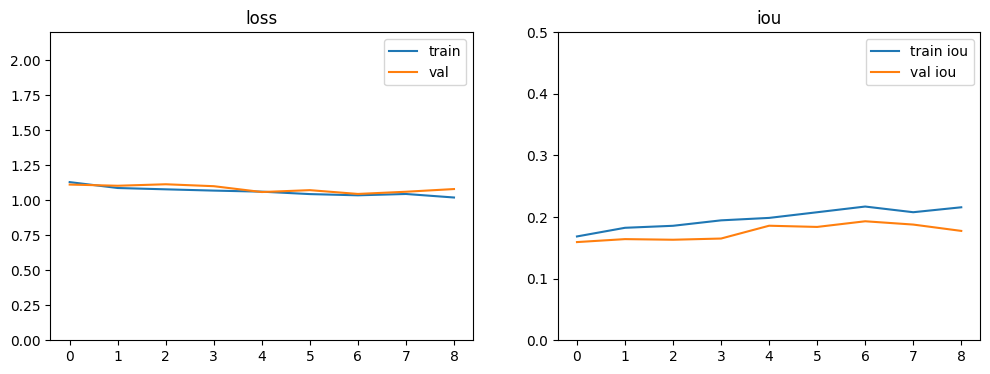

In [ ]:
# def plot_history(history, title='', axs=None, exp_name=""):
#     if axs is not None:
#         ax1, ax2 = axs
#     else:
#         f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

#     if len(exp_name) > 0 and exp_name[0] != '_':
#         exp_name = '_' + exp_name
#     ax1.plot(history.history['loss'], label = 'train' + exp_name)
#     ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
#     ax1.set_ylim(0., 2.2)
#     ax1.set_title('loss')
#     ax1.legend()

#     ax2.plot(history.history['iou_score'], label='train iou'  + exp_name)
#     ax2.plot(history.history['val_iou_score'], label='val iou'  + exp_name)
#     ax2.set_ylim(0, 0.5)
#     ax2.set_title('iou')
#     ax2.legend()
#     return (ax1, ax2)

# plot_history(history)
# plt.show

In [ ]:
print(1)